In [30]:
from IPython.display import clear_output
!pip install cleverhans
clear_output()

import logging
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
# ])

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Input size large enough for downsampling
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [34]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
def show_samples(dataset, classes):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax in axes:
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        img = (img / 2 + 0.5).numpy()  # Unnormalize
        img = np.transpose(img, (1, 2, 0))  # Convert to HWC format
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis('off')
    plt.show()

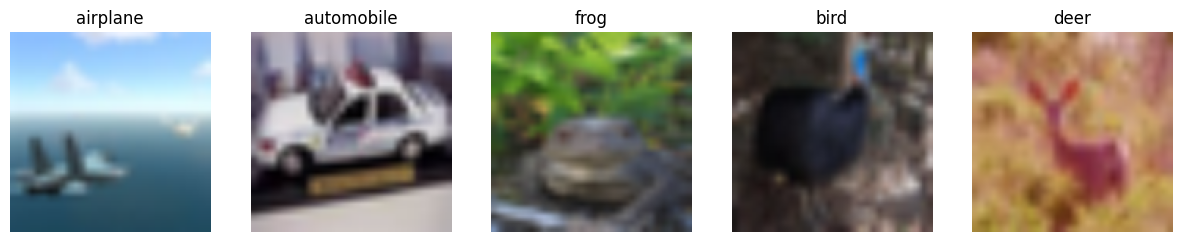

In [36]:
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

show_samples(test_dataset, classes)

In [37]:
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
target_model = target_model.to(device)
target_model.eval()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [38]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the pretrained ResNet-20 model on the test set: {accuracy:.2f}%")


Accuracy of the pretrained ResNet-20 model on the test set: 10.52%


In [39]:
def generate_adversarial_examples(model, data_loader, epsilon):
    original_images = []
    adversarial_images = []
    labels = []
    successes = 0
    total = 0
    model.eval() #//TODO::WTF::

    for images, targets in data_loader:
        images, targets = images.to(device), targets.to(device)
        original_images.append(images)
        labels.append(targets)
        images.requires_grad = True #//TODO::WTF::

        adv_images = fast_gradient_method(model, images, eps=epsilon, norm=np.inf)
        adversarial_images.append(adv_images)

        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = torch.max(outputs, 1)
            successes += (predicted != targets).sum().item()
            total += targets.size(0)

    success_rate = 100 * successes / total
    return original_images, adversarial_images, labels, success_rate


# def ACODE(model, dataloader, epsilon):
#     for images, labels in dataloader:
#         images, labels = images.to(device), labels.to(device)
#         images.requires_grad = True
#         adv_images_batch = fast_gradient_method(model, images, epsilon, np.inf)
#         adv_images.append(adv_images_batch.detach())
#         original_images.append(images.detach())
#         true_labels.append(labels)
#     return torch.cat(original_images), torch.cat(adv_images), torch.cat(true_labels)
# def ACODE(model, original_images, adversarial_images, labels):
#     with torch.no_grad():
#         original_preds = model(original_images).argmax(dim=1)
#         adv_preds = model(adversarial_images).argmax(dim=1)
#         success = (original_preds != adv_preds).sum().item()
#         total = len(labels)
#     return success / total

In [40]:
epsilon = 0.01

original_images, adversarial_images, labels, success_rate = generate_adversarial_examples(
    target_model, test_loader, epsilon
)

print(f"Attack success rate with epsilon {epsilon}: {success_rate:.2f}%")

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 11.12 MiB is free. Process 3071 has 15.88 GiB memory in use. Of the allocated memory 13.95 GiB is allocated by PyTorch, and 1.63 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def visualize_adversarial_examples(orig_images, adv_images, labels, classes):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        idx = np.random.randint(0, len(orig_images))
        orig_img = orig_images[idx][0]
        adv_img = adv_images[idx][0]
        label = labels[idx][0]

        # Unnormalize images for visualization
        orig_img = (orig_img / 2 + 0.5).cpu().detach().numpy()
        adv_img = (adv_img / 2 + 0.5).cpu().detach().numpy()

        diff_img = np.abs(adv_img - orig_img)

        axes[0, i].imshow(np.transpose(orig_img, (1, 2, 0)))
        axes[0, i].set_title(f"Original: {classes[label]}")
        axes[0, i].axis('off')

        axes[1, i].imshow(np.transpose(adv_img, (1, 2, 0)))
        axes[1, i].set_title("Adversarial")
        axes[1, i].axis('off')

        axes[2, i].imshow(np.transpose(diff_img, (1, 2, 0)))
        axes[2, i].set_title("Difference")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_adversarial_examples(original_images, adversarial_images, labels, classes)

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, random_split
# import torchvision
# from tqdm import tqdm
# import numpy as np

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.encoder = nn.ModuleList([
#             self.down_block(3, 64, normalize=False),
#             self.down_block(64, 128),
#             self.down_block(128, 256),
#             self.down_block(256, 512),
#             # self.down_block(512, 512),
#         ])
#         self.bottleneck = self.down_block(512, 512, normalize=False)
#         self.decoder = nn.ModuleList([
#             self.up_block(512, 512, dropout=True),  # Bottleneck output + last encoder output
#             self.up_block(512 + 512, 512, dropout=True),  # Decoder output + encoder output
#             self.up_block(512 + 256, 256),                # Decoder output + encoder output
#             self.up_block(256 + 128, 128),                # Decoder output + encoder output
#             self.up_block(128 + 64, 64),                  # Decoder output + encoder output
#         ])
#         self.final = nn.Sequential(
#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
#             nn.Tanh()
#         )
    
#     def down_block(self, in_channels, out_channels, normalize=True):
#         layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
#         if normalize:
#             layers.append(nn.BatchNorm2d(out_channels))
#         layers.append(nn.LeakyReLU(0.2))
#         return nn.Sequential(*layers)
    
#     def up_block(self, in_channels, out_channels, dropout=False):
#         layers = [
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU()
#         ]
#         if dropout:
#             layers.append(nn.Dropout(0.5))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         skip_connections = []
#         for i, down in enumerate(self.encoder):
#             x = down(x)
#             skip_connections.append(x)

#         # skip_connections = []
#         # for down in self.encoder:
#         #     x = down(x)
#         #     skip_connections.append(x)
#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]
#         for idx, up in enumerate(self.decoder):
#             x = up(x)
#             if idx < len(skip_connections):
#                 print(f"Before Concatenation (Decoder {idx}): {x.shape}")
#                 print(f"Skip Connection {idx}: {skip_connections[idx].shape}")
#                 x = torch.cat((x, skip_connections[idx]), dim=1)
#                 print(f"After Concatenation (Decoder {idx}): {x.shape}")
#         return self.final(x)  # Returns perturbation G(x)
#         # for idx, up in enumerate(self.decoder):
#         #     x = up(x)
#         #     if idx < len(skip_connections):
#         #         print(f"Before Concatenation (Decoder {idx}): {x.shape}")
#         #         print(f"Skip Connection {idx}: {skip_connections[idx].shape}")
#         #         x = torch.cat((x, skip_connections[idx]), dim=1)
#         #         print(f"After Concatenation (Decoder {idx}): {x.shape}")

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# # # Loss functions
# # def adversarial_loss(output, target):
# #     return nn.CrossEntropyLoss()(output, target)

# # def gan_loss(discriminator_output, real):
# #     target = torch.ones_like(discriminator_output) if real else torch.zeros_like(discriminator_output)
# #     return nn.BCELoss()(discriminator_output, target)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.ModuleList([
            self.down_block(3, 64, normalize=False),
            self.down_block(64, 128),
            self.down_block(128, 256),
            self.down_block(256, 512),
        ])
        self.bottleneck = self.down_block(512, 512, normalize=False)
        self.decoder = nn.ModuleList([
            self.up_block(512 + 512, 512, dropout=True),  # Bottleneck output + last encoder output
            self.up_block(512 + 256, 256),                # Decoder output + encoder output
            self.up_block(256 + 128, 128),                # Decoder output + encoder output
            self.up_block(128 + 64, 64),                  # Decoder output + encoder output
        ])
        self.final = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output 3 channels
            nn.Tanh()
        )
    
    def down_block(self, in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)
    
    def up_block(self, in_channels, out_channels, dropout=False):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def forward(self, x):
        skip_connections = []
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx, up in enumerate(self.decoder):
            x = up(x)
            if idx < len(skip_connections):
                x = torch.cat((x, skip_connections[idx]), dim=1)
        return self.final(x)  # Returns perturbation G(x)


In [ ]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         # Define the encoder part of the U-Net
#         self.encoder = nn.ModuleList([
#             self.down_block(3, 64, normalize=False),
#             self.down_block(64, 128),
#             self.down_block(128, 256),
#             self.down_block(256, 512),
#             # self.down_block(512, 512),
#             # self.down_block(512, 512),
#             self.down_block(512, 512)
#         ])
#         # Bottleneck
#         self.bottleneck = self.down_block(512, 512, normalize=False)
#         # Define the decoder part of the U-Net
#         self.decoder = nn.ModuleList([
#             self.up_block(512 + 512, 512, dropout=True),
#             self.up_block(512 + 512, 512, dropout=True),  # Skip connections double channels
#             self.up_block(512 + 512, 512, dropout=True),
#             self.up_block(512 + 512, 512),
#             self.up_block(512 + 512, 256),
#             self.up_block(256 + 128, 128),
#             self.up_block(128 + 64, 64)
#         ])
#         self.final = nn.Sequential(
#             nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
#             nn.Tanh()
#         )
    
#     def down_block(self, in_channels, out_channels, normalize=True):
#         """Create a down-sampling block."""
#         layers = [
#             nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
#         ]
#         if normalize:
#             layers.append(nn.BatchNorm2d(out_channels))
#         layers.append(nn.LeakyReLU(0.2))
#         return nn.Sequential(*layers)
    
#     def up_block(self, in_channels, out_channels, dropout=False):
#         """Create an up-sampling block."""
#         layers = [
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU()
#         ]
#         if dropout:
#             layers.append(nn.Dropout(0.5))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         skip_connections = []
#         for down in self.encoder:
#             x = down(x)
#             skip_connections.append(x)
#         x = self.bottleneck(x)
#         # Reverse skip connections for the decoder
#         skip_connections = skip_connections[::-1]
#         for idx, up in enumerate(self.decoder):
#             x = up(x)
#             if idx < len(skip_connections):
#                 x = torch.cat((x, skip_connections[idx]), dim=1)
#         return self.final(x)

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, input_channels=3):
#         super(Discriminator, self).__init__()        
#         # Define PatchGAN layers
#         self.model = nn.Sequential(
#             # Layer 1: Conv -> LeakyReLU (No normalization)
#             nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Layer 2: Conv -> BatchNorm -> LeakyReLU
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Layer 3: Conv -> BatchNorm -> LeakyReLU
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Layer 4: Conv -> BatchNorm -> LeakyReLU
#             nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
#             # Final Layer: Conv -> Sigmoid (Output single-channel)
#             nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

In [ ]:
def adversarial_loss(output, target):
    return nn.CrossEntropyLoss()(output, target)

# def gan_loss(discriminator_output, real):
#     target = torch.ones_like(discriminator_output) if real else torch.zeros_like(discriminator_output)
#     return nn.BCELoss()(discriminator_output, target)
def gan_loss(discriminator_output, real):
    target = torch.ones_like(discriminator_output) if real else torch.zeros_like(discriminator_output)
    return torch.mean((discriminator_output - target) ** 2)

# For GANs training, we use the least squares objective proposed by LSGAN [Mao et al., 2017], as it has been shown to produce better results with more stable training.

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
# hinge_loss = torch.mean(torch.clamp(generator(images).norm(2, dim=(1, 2, 3)) - c, min=0))

In [ ]:
lr = 0.001

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-4)
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-4)

In [ ]:
patience = 7 
recorded_g_loss = float('inf') 
recorded_d_loss = float('inf')
epochs_no_improve = 0 

epochs = 50
alpha, beta = 1.0, 0.1  # Weights for GAN and hinge loss
c = 8/255 # 0.01  # Perturbation bound (c) = 8/255 for CIFAR-10
g_losses, d_losses, accuracies = [], [], []

for epoch in range(epochs):
    g_loss_epoch, d_loss_epoch, correct = 0, 0, 0
    total = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{epochs}", ncols=100) as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_output = discriminator(images)
            fake_images = images + generator(images)
            fake_output = discriminator(fake_images.detach())
        
            d_real_loss = gan_loss(real_output, True)
            d_fake_loss = gan_loss(fake_output, False)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)  # Clip gradients
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            adv_loss = adversarial_loss(target_model(fake_images), labels)
            hinge_loss = torch.mean(torch.clamp(generator(images).norm(2, dim=(1, 2, 3)) - c, min=0))
            gan_gen_loss = gan_loss(discriminator(fake_images), True)
        
            g_loss = adv_loss + alpha * gan_gen_loss + beta * hinge_loss
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)  # Clip gradients
            g_optimizer.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            
            with torch.no_grad():
                total += labels.size(0)
                pred = target_model(fake_images).argmax(dim=1)
                correct += (pred != labels).sum().item()

            tepoch.set_postfix(
                g_loss=f"{g_loss.item():.4f}",
                d_loss=f"{d_loss.item():.4f}",
                accuracy=f"{100 * correct / total:.2f}%"
            )

    g_loss_epoch /= len(train_loader)
    d_loss_epoch /= len(train_loader)
    accuracy = 100 * correct / total

    g_losses.append(g_loss_epoch)
    d_losses.append(d_loss_epoch)
    accuracies.append(accuracy)

    if g_loss_epoch < recorded_g_loss or d_loss_epoch < recorded_d_loss:
        recorded_g_loss = min(g_loss_epoch, recorded_g_loss)
        recorded_d_loss = min(d_loss_epoch, recorded_d_loss)
        epochs_no_improve = 0
    else:
        print(f"Epochs without improvement: {epochs_no_improve + 1}/{patience}")
        epochs_no_improve += 1
        
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
print(f"Recorded Generator Loss: {recorded_g_loss:.4f}")
print(f"Recorded Discriminator Loss: {recorded_d_loss:.4f}")
# print(f"Recorded Accuracy: {recorded_accuracy:.2f}%")

# Recorded Generator Loss: 1.2393
# Recorded Discriminator Loss: 1.3054

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(range(1, epochs + 1), g_losses, label="Generator Loss")
# plt.plot(range(1, epochs + 1), d_losses, label="Discriminator Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Loss vs Epochs")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, epochs + 1), accuracies, label="Attack Success Rate")
# plt.xlabel("Epochs")
# plt.ylabel("Success Rate (%)")
# plt.title("Attack Success vs Epochs")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
def plot_training_metrics(g_losses, d_losses, accuracies):
    epochs = range(1, len(g_losses) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Generator and Discriminator Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, g_losses, label="Generator Loss", color='blue')
    plt.plot(epochs, d_losses, label="Discriminator Loss", color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss")
    plt.legend()
    plt.grid(True)
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Attack Success Rate", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Attack Success Rate")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_metrics(g_losses, d_losses, accuracies)
